In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [45]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)
# reflect the tables

In [50]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [53]:
# columns in 'measurement' table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
#print(columns)

for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [54]:
# columns in 'measurement' table
inspector = inspect(engine)
columns = inspector.get_columns('station')
#print(columns)

for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [55]:
Start_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


In [56]:
# 12 months starting from 2012-11-24 (datetime string for plotting purposes)
Start_date = dt.date(2017, 8,23)
Start_date


datetime.date(2017, 8, 23)

In [57]:
# Calculate the date 1 year ago from the last data point in the database
# 12 months before 2017-08-23 (12 months = 365 days )
query_date = dt.date(2017, 8,23) - dt.timedelta(days=365)
print("Query Date", query_date)
query_date

Query Date 2016-08-23


datetime.date(2016, 8, 23)

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (2016-08-23 to 2017-08-23)
# Perform a query to retrieve the data and precipitation scores
precipitation_12month = session.query(Measurement.date, Measurement.prcp).\
    filter (Measurement.date >= query_date).all()

precipitation_12month

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(precipitation_12month, columns=['Date','Precipitation'])
df.dropna(axis=0, how='any', inplace= True)
df.sort_values(by='Date')
df.set_index('Date', inplace=True)

df.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


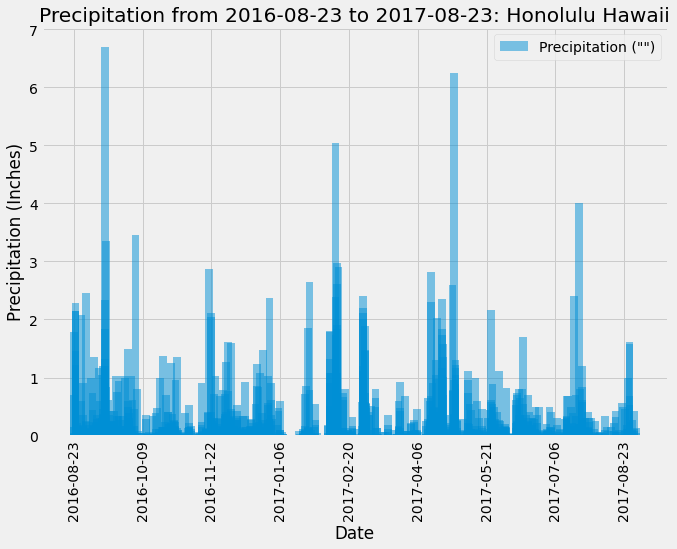

In [59]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = df.index.tolist()
yy = df['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 , alpha=0.5, align="center",label='Precipitation ("")')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
major_ticks = np.arange(0,365,44.7) #dates along bottom match title (2016-08-23 to 2017-08-23)
plt.xticks(major_ticks, rotation='vertical')

plt.title(f"Precipitation from {query_date} to {Start_date}: Honolulu Hawaii")
plt.xlabel("Date")
plt.ylabel(f"Precipitation (Inches)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [60]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [61]:
# Design a query to show how many stations are available in this dataset?


In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [65]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [66]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [67]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [69]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [70]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [71]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [72]:
# Plot the daily normals as an area plot with `stacked=False`
